# Test out VAEs

In [100]:
import os
import sys
import json
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from IPython.display import display, HTML
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import torch
from torchvision import transforms
import torchvision.transforms.functional as TF
from PIL import Image


# Nicer way to import the module?
sys.path.append(str(Path.cwd().parent))

from utils.display import read_img_to_np, torch_to_np
from utils.norms import MNIST_norm
import model.model as module_arch
import data_loader.data_loaders as module_data
import model.loss as module_loss
import model.metric as module_metric
device = torch.device("cuda:1")

# from utils.loading import load_net
# from utils.data import make_generators_DF
# from utils.train_val import validate_epoch
# from utils.evaluation import evaluate_adv_files_df, get_metrics

In [95]:
def get_model_loaders_config(PATH, old_gpu='cuda:0', new_gpu='cuda:1'):
    """PATH: path to dir where training results of a run are saved"""
    PATH = Path(PATH)
    config_loc = PATH / 'config.json'
    weight_path = PATH / 'model_best.pth'
    config = json.load(open(config_loc))
    
    
    def get_instance(module, name, config, *args):
        return getattr(module, config[name]['type'])(*args, **config[name]['args'])

    data_loader = get_instance(module_data, 'data_loader', config)['train']
    valid_data_loader = get_instance(module_data, 'data_loader', config)['val']
    model = get_instance(module_arch, 'arch', config)
    model = model.to(torch.device(new_gpu))
    checkpoint = torch.load(weight_path, map_location={'cuda:0': 'cuda:1'})
    state_dict = checkpoint['state_dict']
    
    if config['n_gpu'] > 1:
        model = torch.nn.DataParallel(model)

    model.load_state_dict(state_dict)
    model = model.to(device).eval()
    
    loss_fn = get_instance(module_loss, 'loss', config)
    metric_fns = [getattr(module_metric, met) for met in config['metrics']]
    
    return model, data_loader, valid_data_loader, loss_fn, metric_fns, config


def display_results_auto(vae_model, config, device, rotate=0, 
                         norm=None, num_samples=3, data='bw', size = 28, label_col_name='label', save_loc=None):
    with torch.cuda.device(device.index): # ??? Why the fuck???        
        files_dict_loc = config['data_loader']['args']['files_dict_loc']
        with open(files_dict_loc, 'rb') as f:
            files_df = pickle.load(f)['train']
            
        if label_col_name:
            all_labels = files_df[label_col_name].unique()
        else:
            all_labels = list(range(num_samples))
        row_names = []
        col_names = ['Original', "Reconstructed"]

        fig, ax = plt.subplots(num_samples, 2, sharex='col', sharey='row',figsize=(10,10))

        for i, label in enumerate(all_labels[0:num_samples]):
            if label_col_name:
                sample_df = files_df.loc[files_df[label_col_name] == label].sample(n=1)
                label = sample_df[label_col_name].iloc[0]
                row_names.append(label)
            else:
                sample_df = files_df.sample(n=1)
            img_path = sample_df['path'].iloc[0]

            if data == 'bw': # Assume MNIST
                img = read_img_to_np(img_path, bw=True)
                transform = transforms.Compose([
                                                transforms.RandomRotation((rotate, rotate), expand=True),
                                                transforms.Resize(size),
                                                transforms.Pad((6, 6)),
                                                transforms.ToTensor(),
                                                transforms.Normalize(*MNIST_norm)])
            else:
                img = read_img_to_np(img_path, bw=False, size=size)
                transform = transforms.Compose([
                                                transforms.RandomRotation((rotate, rotate), expand=True),
                                                transforms.Resize(size),
                                                transforms.ToTensor(),
                                                transforms.Normalize(*norm)])

            tensor_img = transform(Image.open(img_path)).unsqueeze(0).to(device)
            tensor_label = torch.from_numpy(np.array(label)).unsqueeze(0).type(torch.LongTensor).to(device)

            output = model(tensor_img,  deterministic=False)
            recon_x = output[0]
            
            ax[i, 0].imshow(torch_to_np(tensor_img), cmap='Greys',  interpolation='nearest')
            ax[i, 1].imshow(torch_to_np(recon_x), cmap='Greys',  interpolation='nearest')
            ax[i, 0].axis('off')
            ax[i, 1].axis('off')

        for curr_ax, col in zip(ax[0], col_names):
            curr_ax.set_title(col)
        if label_col_name:
            for curr_ax, row in zip(ax[:,0], row_names):
                curr_ax.set_ylabel(row, rotation=0, size='large')
        if save_loc:
            plt.savefig(save_loc, bbox_inches='tight')

### MNIST - Check standard autoencoder

RuntimeError: size mismatch, m1: [1 x 1600], m2: [784 x 32] at /pytorch/aten/src/THC/generic/THCTensorMathBlas.cu:249

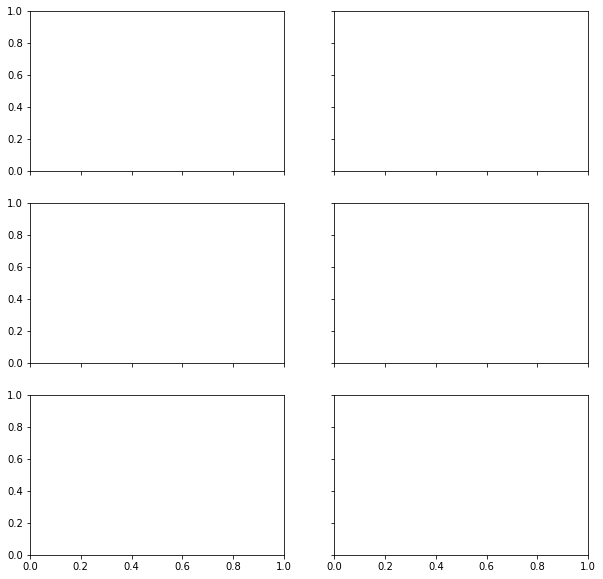

In [96]:
PATH = '/media/rene/data/equivariance/mnist/vae_mnist_L32/0114_133313'
model, data_loader, valid_data_loader, loss_fn, metric_fns, config = get_model_loaders_config(PATH, old_gpu='cuda:1', new_gpu='cuda:1')
display_results_auto(model, config, device, rotate=0, num_samples=3, label_col_name='class', save_loc=None)

## Perfromance on rotated images
* Test the performance on rotated samples 
* Model was not trained with rotation

In [97]:
def get_vae_perf(model, data_loader, loss_fn, metric_fns, device, rotation=None, resized_crop=None):
    """For a vae, not cvae. for mnist"""
    with torch.cuda.device(device.index):
        img_size = 28
        model = model.to(device)
        model.eval()

        total_loss = 0.0
        total_metrics = torch.zeros(len(metric_fns))

        with torch.no_grad():
            for i, (data, target) in enumerate(tqdm(data_loader)):
                batch_size = data.shape[0]
                
                # Do transforms (transforms done in PIL)
                for i in range(batch_size):
                    img = TF.to_pil_image(data[i, :, :])
#                     img = TF.affine(img, rotation, translate=(0, 0), scale=1, shear=0)
                    if rotation:
                        img = TF.rotate(img, rotation)
                    if resized_crop:
                        i = (img_size - 28)/2 
                        img = TF.resized_crop(img, 4, 4, resized_crop, resized_crop, (img_size, img_size))
                    data[i, :, :] = TF.to_tensor(img)
                
                data, target = data.to(device), target.to(device)                
                output = model(data)

                # computing loss, metrics on test set
                loss = loss_fn(output, data)
                total_loss += loss.item() * batch_size
                for i, metric in enumerate(metric_fns):
                    total_metrics[i] += metric(output, data) * batch_size

        n_samples = len(data_loader.sampler)
        log = {'loss': total_loss / n_samples}
        log.update({met.__name__ : total_metrics[i].item() / n_samples for i, met in enumerate(metric_fns)})
        print(log)

In [98]:
PATH = '/media/rene/data/equivariance/mnist/vae_mnist_L32/0114_133313'
model, data_loader, valid_data_loader, loss_fn, metric_fns, config = get_model_loaders_config(PATH, old_gpu='cuda:1', new_gpu='cuda:1')

get_vae_perf(model, valid_data_loader, loss_fn, metric_fns, device, rotation=10)

NameError: name 'rotation_aug' is not defined

In [54]:
get_vae_perf(model, valid_data_loader, loss_fn, metric_fns, device, rotation=90)

100%|██████████| 40/40 [00:01<00:00, 21.21it/s]

{'loss': 65856.3617078125, 'BCE': 55247.872, 'KLD': 10608.4872}


In [55]:
get_vae_perf(model, valid_data_loader, loss_fn, metric_fns, device, rotation=180)

100%|██████████| 40/40 [00:01<00:00, 22.73it/s]

{'loss': 65607.2440203125, 'BCE': 54976.5824, 'KLD': 10630.6712}


In [56]:
get_vae_perf(model, valid_data_loader, loss_fn, metric_fns, device, rotation=-90)

100%|██████████| 40/40 [00:01<00:00, 21.71it/s]

{'loss': 65896.17305625, 'BCE': 55285.6768, 'KLD': 10610.5}


In [76]:
get_vae_perf(model, valid_data_loader, loss_fn, metric_fns, device, rotation=45)

100%|██████████| 40/40 [00:01<00:00, 21.37it/s]

{'loss': 53047.013478515626, 'BCE': 41819.424, 'KLD': 11227.5928}


In [99]:
5/7

[autoreload of data_loader.data_loaders failed: Traceback (most recent call last):
  File "/media/rene/ADV/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/media/rene/ADV/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 368, in superreload
    module = reload(module)
  File "/home/rene/miniconda3/lib/python3.6/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/home/rene/miniconda3/lib/python3.6/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 618, in _exec
  File "<frozen importlib._bootstrap_external>", line 674, in exec_module
  File "<frozen importlib._bootstrap_external>", line 781, in get_code
  File "<frozen importlib._bootstrap_external>", line 741, in source_to_code
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/media/rene/code/equivaria

0.7142857142857143